In [1]:
import pytesseract
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import wiener
import csv

In [2]:
image_file = "C:/Users/49176/OneDrive/Desktop/OCR/greek_letters.png"

# Basic functions for Image Preprocessing with open cv

In [3]:
# load image with open cv
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Fehler: Bild konnte nicht geladen werden.")
    else:
        print("Bild erfolgreich geladen.")
    return image

In [4]:
# display image
def display_image(image, title="Image"):
    plt.figure(figsize=(12, 8))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()
    

In [5]:
# produce a grayscale image
def grayscale_image(image):  
    grayscaled_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return grayscaled_image

In [6]:
# invert an image
def invert_image(image):
    inverted_image = cv2.bitwise_not(image)
    return inverted_image

In [7]:
# create a binary image
def binary_image(image):
    thresh, bin_image = cv2.threshold(image, 170, 240, cv2.THRESH_BINARY)  #there is also cv2.THRESH_OTSU
    return bin_image

In [8]:
# erode image
def erode_image(image):
    image = cv2.bitwise_not(image)
    kernal = np.ones((2,2),np.uint8)
    image = cv2.erode(image, kernal, iterations = 1)
    image = cv2.bitwise_not(image)
    return image

In [9]:
# dilate image
def dilate_image(image):
    image = cv2.bitwise_not(image)
    kernal = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernal, iterations = 1)
    image = cv2.bitwise_not(image)
    return image

In [10]:
# blur image
def blur_image(image):
    kernal=(5,5)
    blurred_image = cv2.GaussianBlur(image, kernal, sigmaX=0)
    return blurred_image

In [11]:
# deblur image (gray_scale)
def wiener_filter(image):
    image = cv2.bitwise_not(image)
    kernal=(2,2)
    filtered_image = wiener(image, kernal)
    #filtered_image = cv2.bitwise_not(filtered_image)
    return np.uint8(filtered_image)  

# specific functions for better OCR results

In [12]:
# find countours (binary image)
def find_contours(bin_image):
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    return contours, hierarchy

In [13]:
# find countours with edges (binary image)
def find_contours_with_canny_edges(bin_image):
    edges = cv2.Canny(bin_image, 100, 200)
    contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    return contours, hierarchy, edges  

In [14]:
# remove horizontal lines 
def remove_horizontal_lines(image):
    image = cv2.bitwise_not(image)
    horizontal_kernal = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
    horizontal_lines = cv2.morphologyEx(image, cv2.MORPH_OPEN, horizontal_kernal)
    no_horizontal_lines_image = cv2.subtract(image, horizontal_lines)
    no_horizontal_lines_image = cv2.bitwise_not(no_horizontal_lines_image)
    return no_horizontal_lines_image

In [15]:
# remove vertical lines 
def remove_vertical_lines(image):
    image = cv2.bitwise_not(image)
    vertical_kernal = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
    vertical_lines = cv2.morphologyEx(image, cv2.MORPH_OPEN, vertical_kernal)
    no_vertical_lines_image = cv2.subtract(image, vertical_lines)
    no_vertical_lines_image = cv2.bitwise_not(no_vertical_lines_image)
    return no_vertical_lines_image

# OCR on tables

In [16]:
# Konfiguriere Tesseract
pytesseract.pytesseract.tesseract_cmd = "C://Program Files//Tesseract-OCR//tesseract.exe"

In [17]:
def save_to_csv(table_data, output_path):
    """Speichert die extrahierte Tabelle in eine CSV-Datei."""
    with open(output_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerows(table_data)

In [18]:
# extract table 
def extract_table(image):
    custom_config = r'--oem 1 --psm 6'
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    bounding_boxes = [box for box in bounding_boxes if box[2] > 100 and box[3] > 100]  # Filter
    bounding_boxes = sorted(bounding_boxes, key=lambda x: (x[1], x[0]))
    if not bounding_boxes:
        return [] 
    rows = []
    mean_height = np.mean([box[3] for box in bounding_boxes])
    current_row = [bounding_boxes[0]]

    for box in bounding_boxes[1:]:
        if abs(box[1] - current_row[-1][1]) <= mean_height:
            current_row.append(box)
        else:
            rows.append(current_row)
            current_row = [box]
    rows.append(current_row)
    for row in rows:
        row.sort(key=lambda x: x[0])
    table_data = []
    for row in rows:
        row_data = []
        for (x, y, w, h) in row:
            cell = image[y:y + h, x:x + w]
            text = pytesseract.image_to_string(cell, config=custom_config)
            row_data.append(text)
        table_data.append(row_data)

    return table_data


In [19]:
def split_texts_in_array(input_array):
    return [text.split("\n") for text in input_array]

Testing area

In [20]:
image = load_image(image_file)
grayscaled_image = grayscale_image(image)
bin_image = binary_image(grayscaled_image)
table = extract_table(bin_image)
table_2 = table[0]
new_text = split_texts_in_array(table_2)
print(new_text)

Bild erfolgreich geladen.
[['‘Upperease Lowercase Name ‘Uppercase Lowercase Name', 'A o alpha N y nu', '', 'B 6 deta 3 g xi', '', 'Tr Y gamma O ° omicron', '4 8 delta iy . pi', '', 'E e epsilon P p tho', '', 'Z & zeta z ° sigma', 'H ny eta T t tau', '', 'i) 8 theta Y v upsilon', 'I ‘ iota ® 6 phi', '', 'K « kappa x x chi', '', 'A a lambda ¥ ¥ psi', '', 'M a mu 2 @ omega', '']]


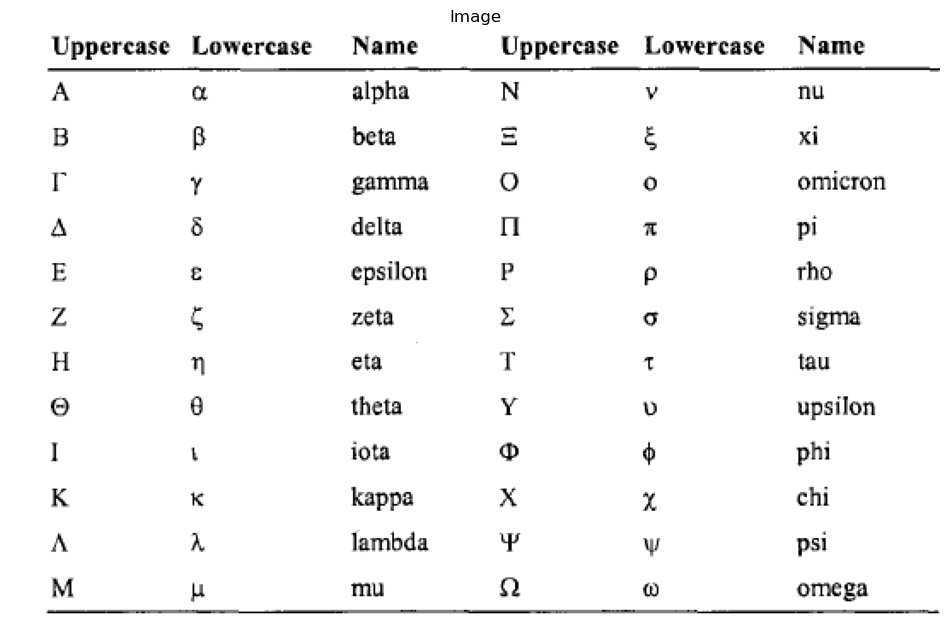

In [21]:
display_image(image)

In [22]:
image = load_image(image_file)
grayscaled_image = grayscale_image(image)
inverted_image = invert_image(grayscaled_image)
bin_image = binary_image(grayscaled_image)
eroded_image = erode_image(image)
dilated_image = dilate_image(image)
blured_image = blur_image(grayscaled_image)
filtered_image = wiener_filter(blured_image)
image_without_horizontal_lines = remove_horizontal_lines(image)
image_without_vertical_lines = remove_vertical_lines(image)

Bild erfolgreich geladen.


c:\Users\49176\anaconda3\Lib\site-packages\scipy\signal\_signaltools.py:1657: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
c:\Users\49176\anaconda3\Lib\site-packages\scipy\signal\_signaltools.py:1657: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
C:\Users\49176\AppData\Local\Temp\ipykernel_10788\3413575259.py:7: RuntimeWarning: invalid value encountered in cast
  return np.uint8(filtered_image)


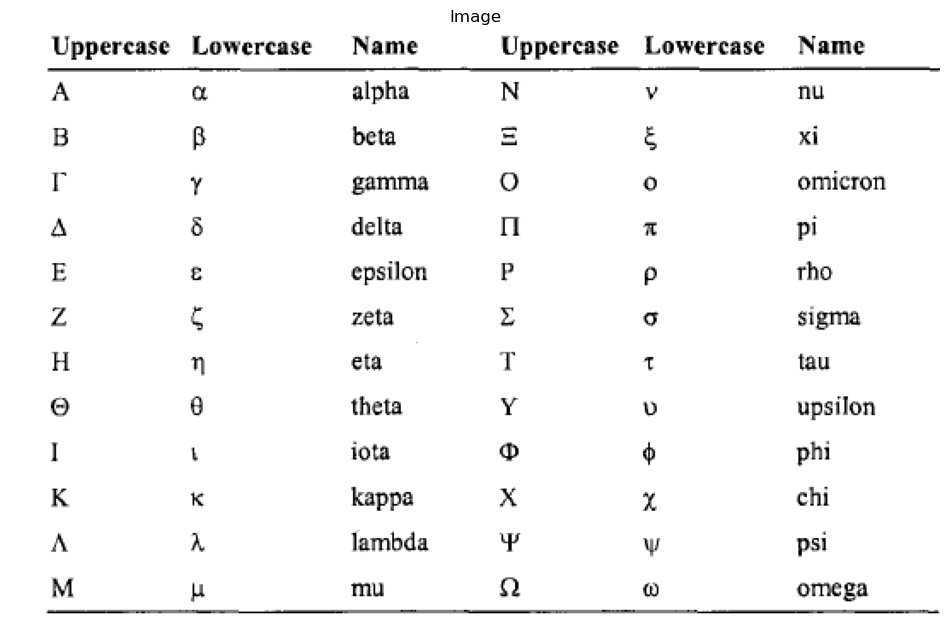

In [23]:
display_image(image)

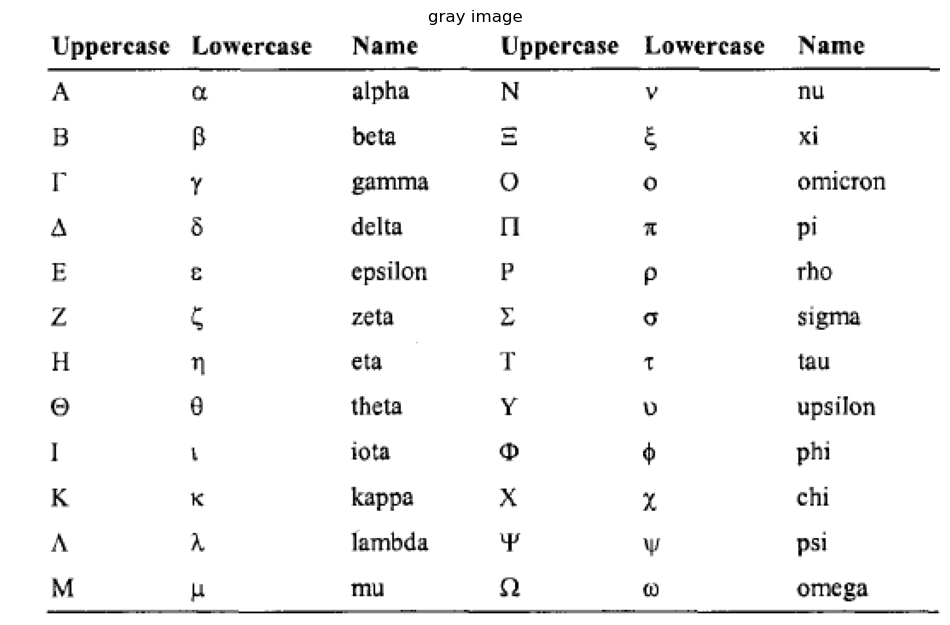

In [24]:
display_image(grayscaled_image,"gray image")

In [25]:
def remove_borders(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    x_min, y_min, x_max, y_max = image.shape[1], image.shape[0], 0, 0
    
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)
    
    cropped_image = image[y_min:y_max, x_min:x_max]
    
    return cropped_image

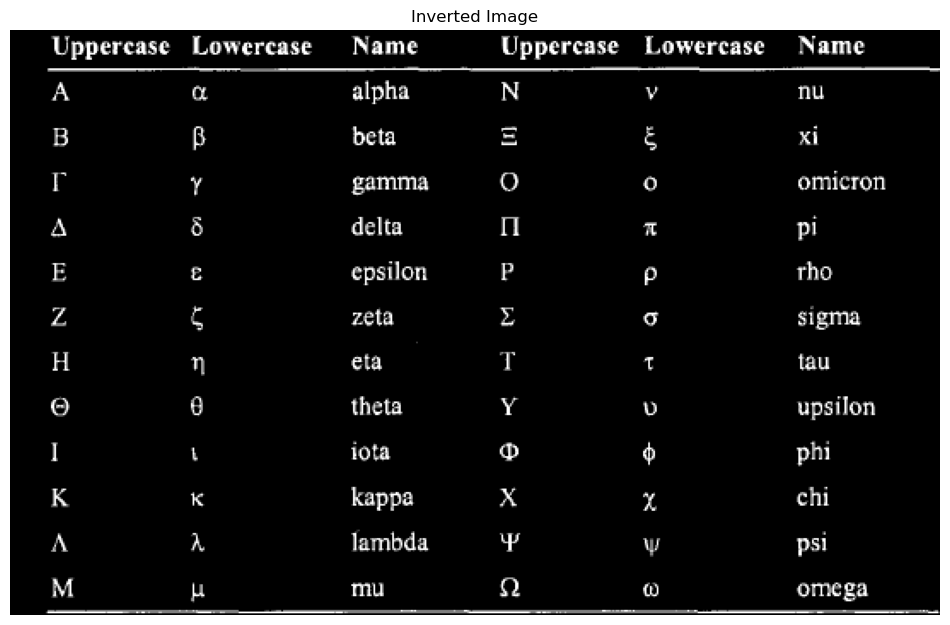

In [26]:
display_image(inverted_image,"Inverted Image")

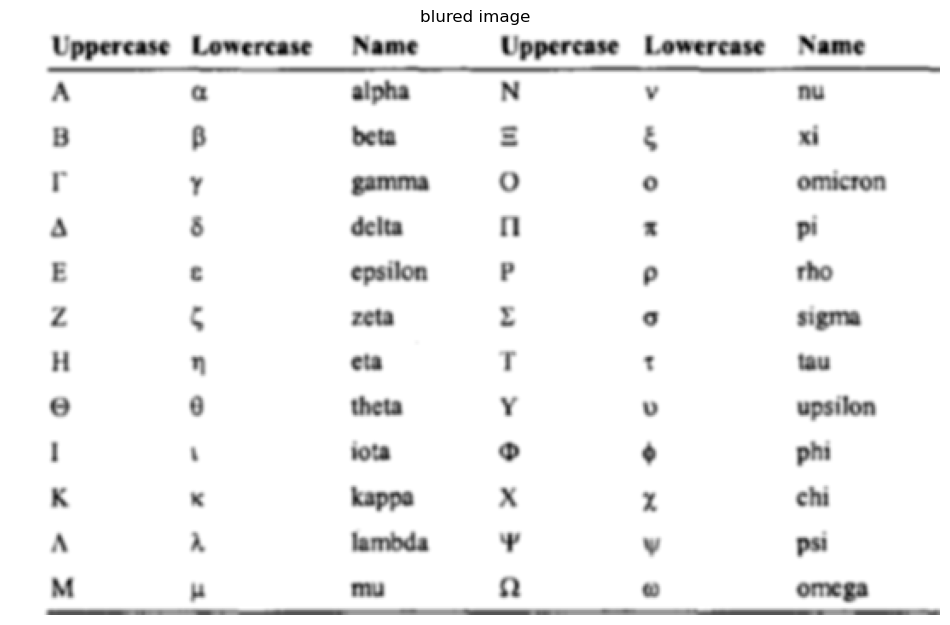

In [27]:
display_image(blured_image,"blured image")

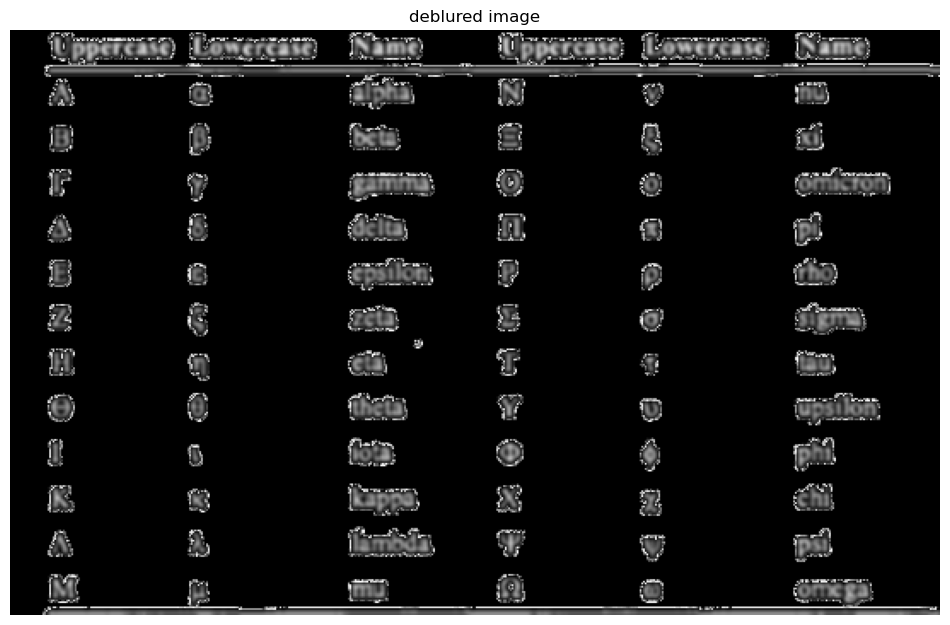

In [28]:
display_image(filtered_image,"deblured image")

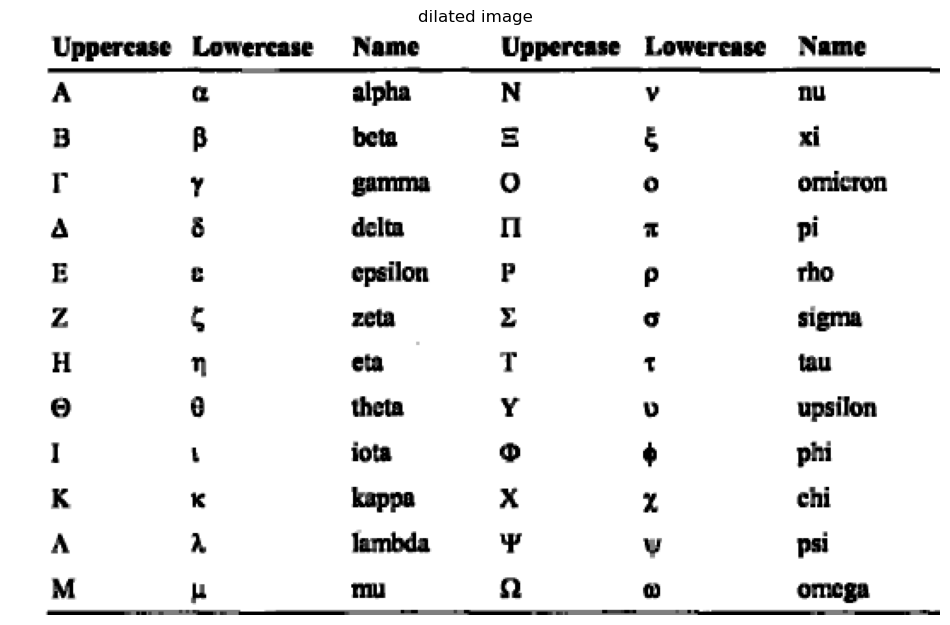

In [29]:
display_image(dilated_image,"dilated image")

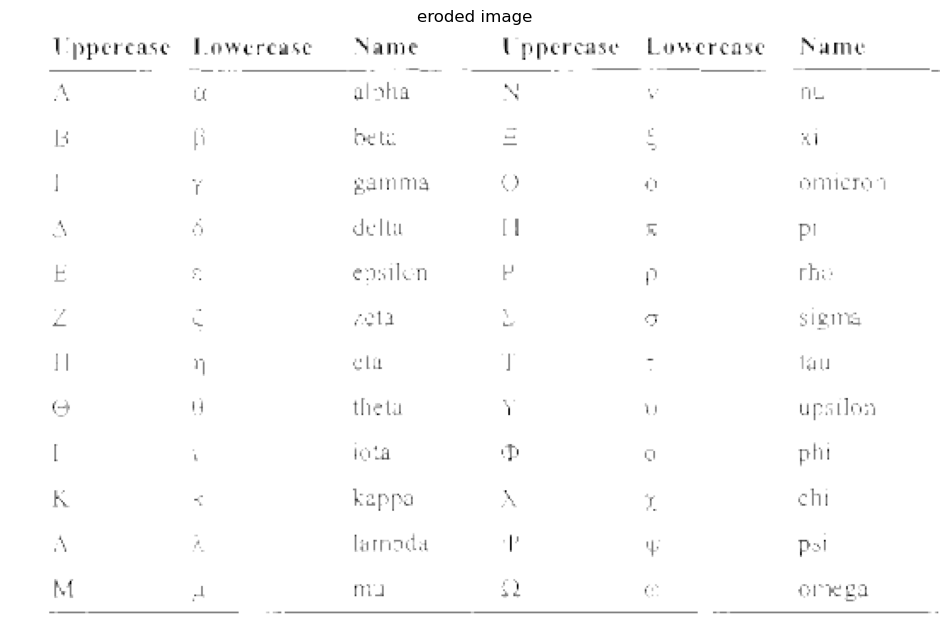

In [30]:
display_image(eroded_image,"eroded image")

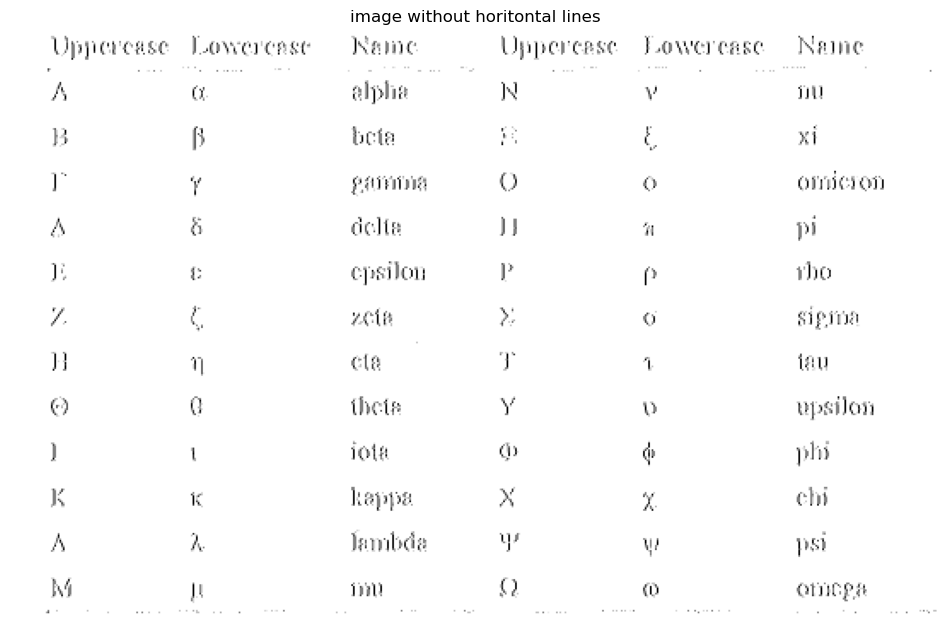

In [31]:
display_image(image_without_horizontal_lines,"image without horitontal lines")

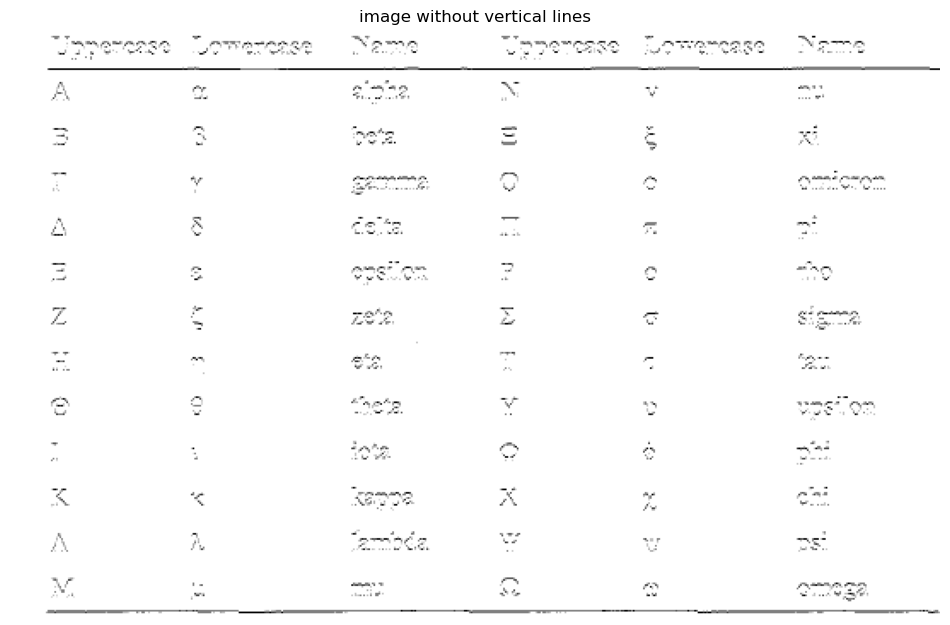

In [32]:
display_image(image_without_vertical_lines,"image without vertical lines")